# Classification. Linear models and KNN

In [675]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [676]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [677]:
from sklearn.exceptions import NotFittedError

In [678]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_values = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1.0 / (1.0 + np.exp(-np.dot(X, weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        items_for_addition = []
        for i in range(x.shape[0]):
            item =  np.log(1 + np.exp(-weights[1:] @ x[i] * y[i]))
            items_for_addition.append(item)
        loss = np.sum(items_for_addition, axis=0) / x.shape[0] + weights.T @ weights / (2 * self.C)

        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            self.loss_values.append(self.get_loss(X, self.weights_, y))
            items_for_addition = []
            for i in range(y.shape[0]):
                item = y[i] * X_ext[i, :] * (1 - 1 / (1 + np.exp(-X_ext[i, :] @ self.weights_ * y[i])))
                items_for_addition.append(item)
            delta = -np.sum(np.array(items_for_addition), axis=0) / X_ext.shape[0] + self.weights_/self.C
            self.weights_ -= self.eta * delta
            w_t = self.weights_ + self.eta * delta
            if (np.linalg.norm(w_t - self.weights_) < self.tol):
                break
    
    def return_get_loss():
        return self.loss_values
    
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        if hasattr(self, 'weights_'):
            cl = self.predict_proba(X)
            return np.where(cl < 0.5, -1, 1)
        else:
            raise NotFittedError('is not fitted yet')

In [679]:
from sklearn import datasets
from sklearn import metrics

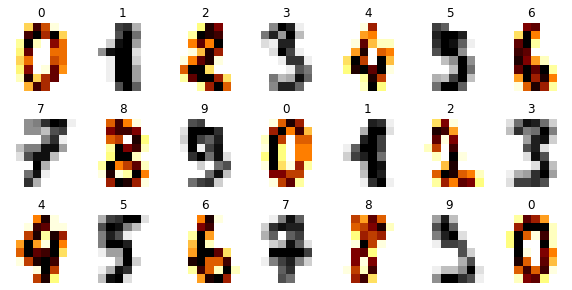

In [680]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [681]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [682]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [683]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [684]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [685]:
lr_clf.fit(X_train, y_train)

In [686]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [687]:
model = CustomLogisticRegression()

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


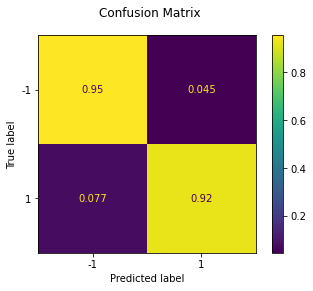

In [688]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [689]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [690]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0, 0.5, 'Loss')

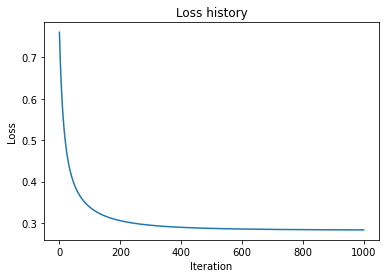

In [691]:
plt.plot(model.loss_values, label='Training')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

As we can see above as number of an iteration increases, loss value decreases.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

Let's try 8 different learning rates, including the initial learning rate.

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


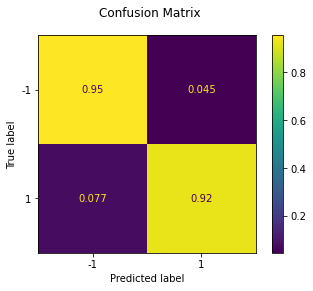

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


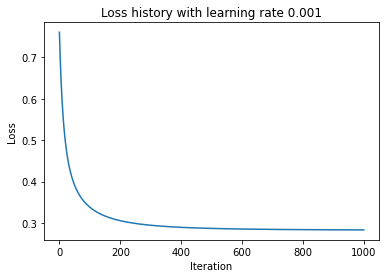

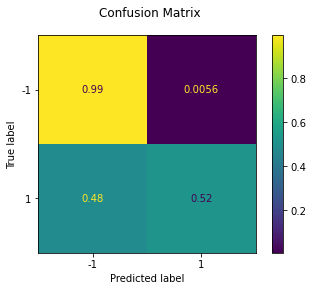

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


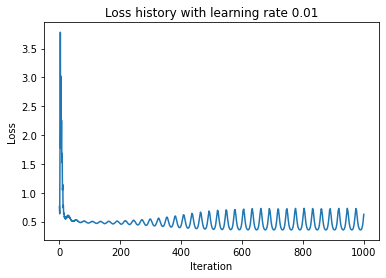

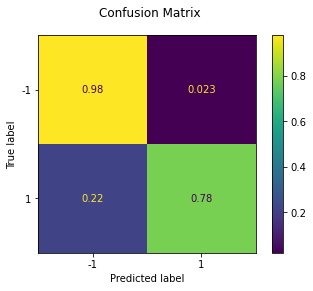

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


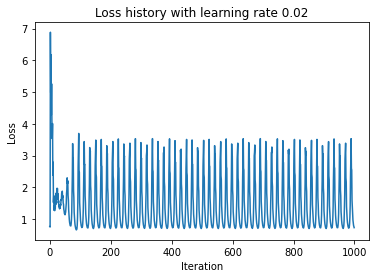

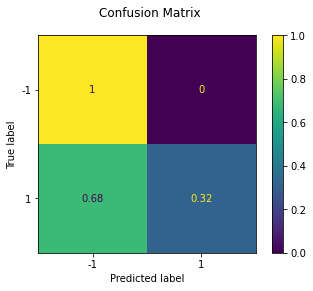

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


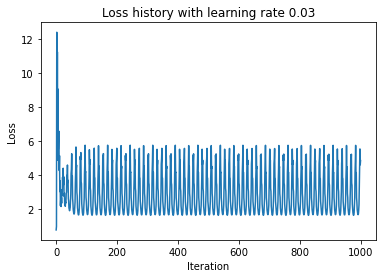

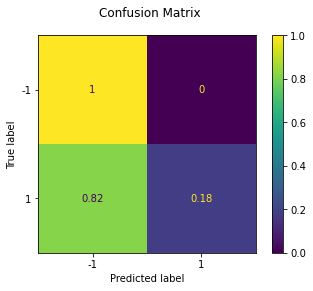

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


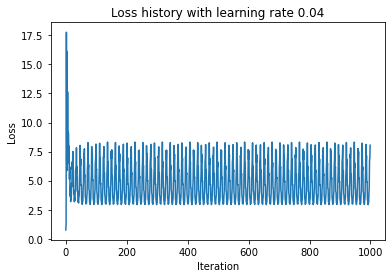

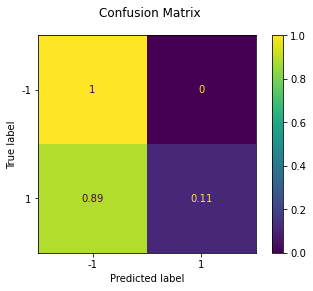

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


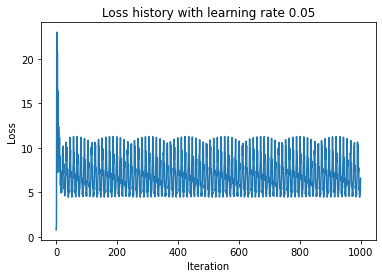

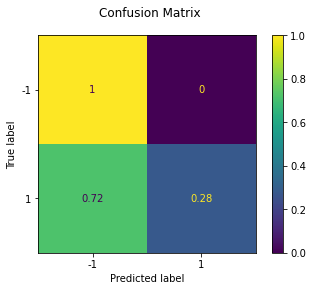

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


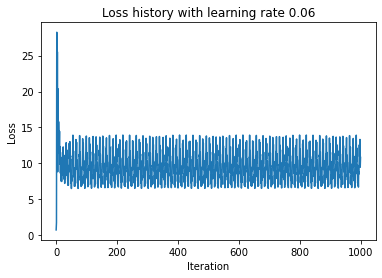

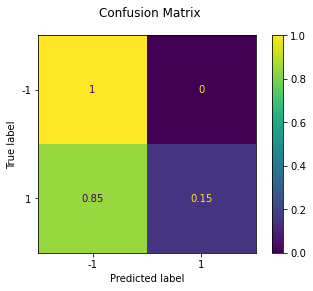

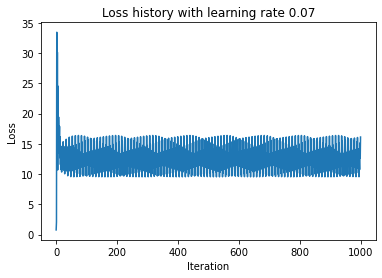

In [692]:
learning_rates = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
for lr in learning_rates:
    model = CustomLogisticRegression(eta=lr)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    plt.plot(model.loss_values, label='Training')
    plt.title(f'Loss history with learning rate {lr}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

**How does the learning rate influence the convergence?** As we can see with the increase of learning rate (etc), gradient descent starts shaking (being unstable) while trying to predict parameters due to the fact that learning rate is too big and it "jumps" over optimal value in the gradient descent. To conclude, learning rate that equals 0.001 allows us to achieve optimal value of loss.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

Let's try 8 different regularization parameters (C).

Confusion matrix with regularization value 0.1


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


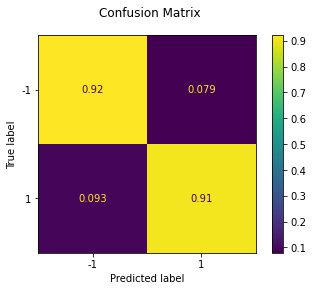

0.8872651356993737 0.9138888888888889
Confusion matrix with regularization value 0.2


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


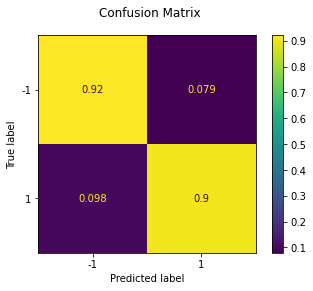

0.8963117606123869 0.9111111111111111
Confusion matrix with regularization value 0.3


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


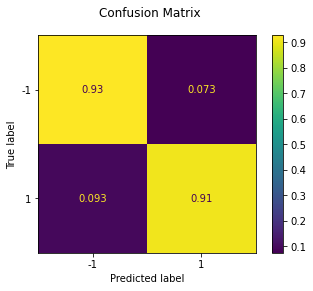

0.8970076548364648 0.9166666666666666
Confusion matrix with regularization value 0.4


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


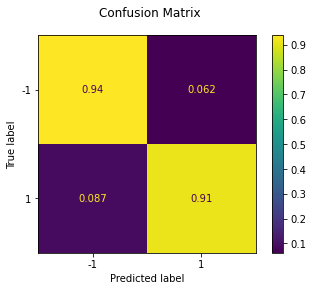

0.9025748086290883 0.925
Confusion matrix with regularization value 0.5


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


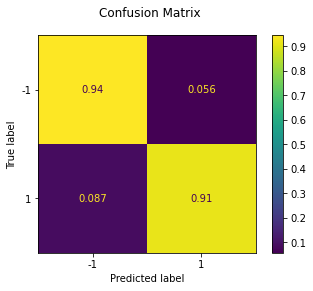

0.9039665970772442 0.9277777777777778
Confusion matrix with regularization value 1


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


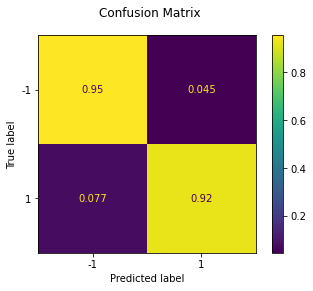

0.9109255393180237 0.9388888888888889
Confusion matrix with regularization value 2


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


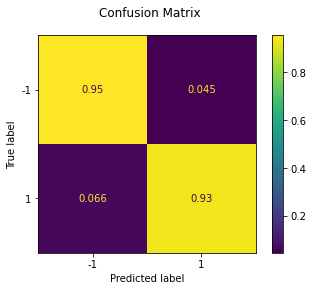

0.9137091162143354 0.9444444444444444
Confusion matrix with regularization value 3


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


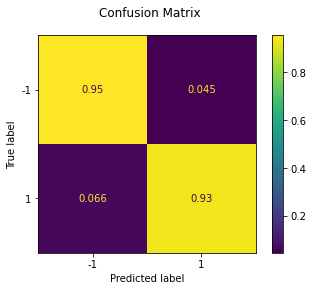

0.9151009046624913 0.9444444444444444


In [693]:
regulatization_values = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3]
for regulatization_value in regulatization_values:
    print(f'Confusion matrix with regularization value {regulatization_value}')
    model = CustomLogisticRegression(C=regulatization_value)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(train_acc, test_acc)

**Compare the modules quality** As we can see with the increase of C (in the function it's written that smaller C specify stronger regularization), the quaility of a model slightly increases. For example, when C is 0.4, accuracy is 0.9025748086290883 0.925. While when C is 3, accuracy is 0.9151009046624913 0.9444444444444444. This increase in quality can be just due to overfitting.

**(0.5 points)** Compare zero initialization and random initialization. 

**Random initialization and Zero initialization with eta = 0.001**

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


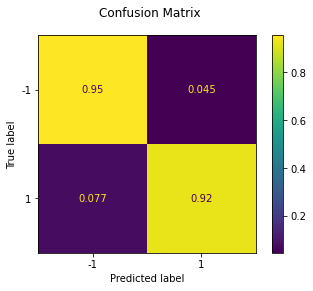

Random initialization accuracy
0.9109255393180237 0.9388888888888889


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


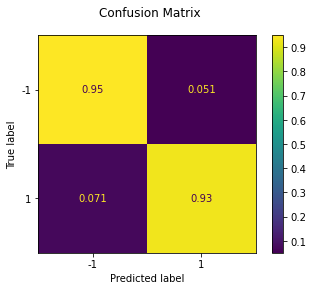

Zero initialization accuracy
0.9116214335421016 0.9388888888888889


Text(0, 0.5, 'Loss')

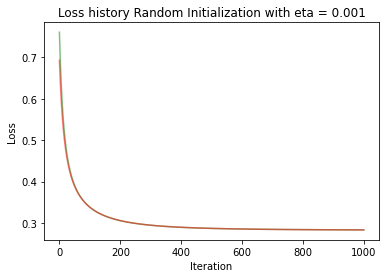

In [694]:
model1 = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(model1, X_train, y_train, X_test, y_test)
print('Random initialization accuracy')
print(train_acc, test_acc)
model2 = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model2, X_train, y_train, X_test, y_test)
print('Zero initialization accuracy')
print(train_acc, test_acc)
plt.plot(model1.loss_values, label='Training', color='green', alpha=0.5)
plt.plot(model2.loss_values, label='Training', color='red', alpha=0.5)
plt.title('Loss history Random Initialization with eta = 0.001')
plt.xlabel('Iteration')
plt.ylabel('Loss')

**Random initialization and Zero initialization with eta = 0.005**

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


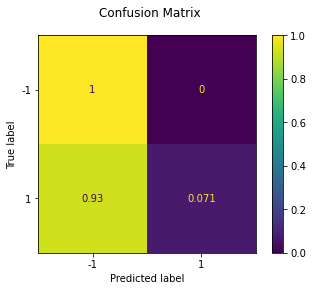

Random initialization accuracy
0.5455810716771051 0.5277777777777778


D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


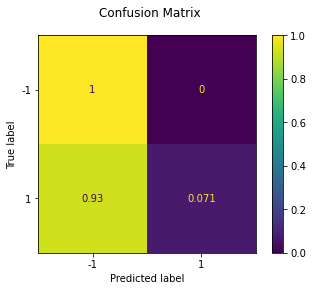

Zero initialization accuracy
0.5455810716771051 0.5277777777777778


Text(0, 0.5, 'Loss')

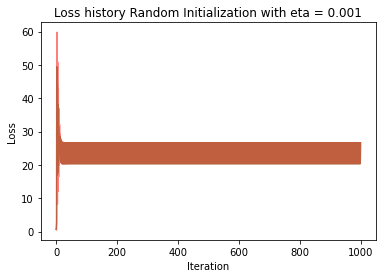

In [695]:
model1 = CustomLogisticRegression(zero_init=False, eta=0.1)
train_acc, test_acc = fit_evaluate(model1, X_train, y_train, X_test, y_test)
print('Random initialization accuracy')
print(train_acc, test_acc)
model2 = CustomLogisticRegression(zero_init=True, eta=0.1)
train_acc, test_acc = fit_evaluate(model2, X_train, y_train, X_test, y_test)
print('Zero initialization accuracy')
print(train_acc, test_acc)
plt.plot(model1.loss_values, label='Training', color='green', alpha=0.5)
plt.plot(model2.loss_values, label='Training', color='red', alpha=0.5)
plt.title('Loss history Random Initialization with eta = 0.001')
plt.xlabel('Iteration')
plt.ylabel('Loss')

**Compare random initialization and zero initialization** As we can see from loss graphs above, loss is similar (almost the same) for random and zero initialization. May be if we took different other parameters, the situation would change. As for the confusion matrices, they are also similar (with etc=0.001 confusion matrix with zero initialization is little better).

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [775]:
from sklearn.metrics.pairwise import pairwise_distances
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        self.probabilities_all = []
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return pairwise_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        weights_sum = pd.DataFrame({"weights": weights, "class_names": y}).groupby(by="class_names").sum()
        ordered_weights = pd.DataFrame(weights_sum, self.classes_).to_numpy().flatten()
        return np.nan_to_num(ordered_weights)
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(self.points, X)
            weights_of_points = 0
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
            else:
                weights_of_points = np.ones(len(P))
        
        else:
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        final_probabilities = []
        for i in range(len(X)):
            mask_for_nearest_neighbors = P[:,i] <= sorted(P[:,i])[self.n_neighbors - 1]
            classes_weights = self.get_class_weights(self.y[mask_for_nearest_neighbors], weights_of_points[:,i][mask_for_nearest_neighbors])
            probability = classes_weights/classes_weights.sum()
            final_probabilities.append(probability)

        return np.array(final_probabilities)
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        self.probabilities_all.append(np.amax(self.predict_proba(X), axis=1))
        return np.argmax(self.predict_proba(X), axis=1)

In [776]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [777]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [778]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

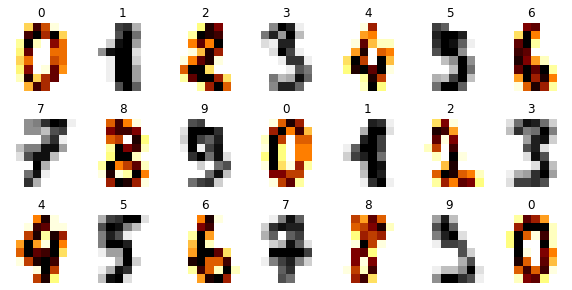

In [779]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [780]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [781]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


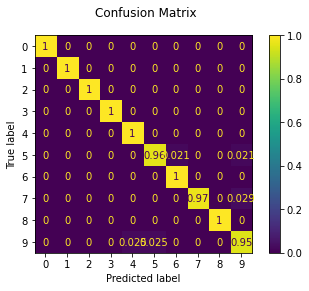

In [782]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [783]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

As we can see from the Confusion matrix above, the model confusses 5 with 6 and 9, 7 with 9, and 9 with 4 and 5. Why this happens? If we look at the pictures of numbers presented to us above, we can see that 5 sometimes look almost as 9 (I personally wouldn't distinguish some fives from nines) and 5 sometimes looks like 6. The same situation with 7 and 9, and 9 with 5 and 4. These numbers written in different handwriting can look exatcly the same even for a human.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

I print confusion matrix, accuracies and probabilities from the model for 4 different n_neighbors parameters.

**As we can see below, when there are 3 neighbors accuracy on test is 0.9833 and the model tends to confuse 5 with 6; 9 with 3, 4, 5; 8 with 1. While probabilities are mostly 1.**

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


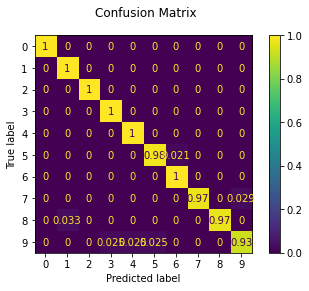

Number of neighbors = 20
Accuracy on train: 1.0
Accuracy on test: 0.9833333333333333
Model probabilities
[array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.69725258, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.  

In [812]:
model = CustomKNeighborsClassifier(n_neighbors=3, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'Number of neighbors = {i}')
print("Accuracy on train:", train_acc)
print("Accuracy on test:", test_acc)
print('Model probabilities')
print(model.probabilities_all)

**As we can see below, when there are 8 neighbors accuracy on test is 0.9861 which is slightly higher than accuracy when there are 3 neighbors and the model tends to confuse 5 with 6; 9 wuth 4, 5; 8 with 1; 7 with 9. While there are more probabilities that are not 1 compared to situation when there are 3 neighbors.**

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


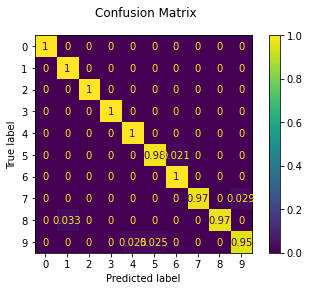

Number of neighbors = 20
Accuracy on train: 1.0
Accuracy on test: 0.9861111111111112
Model probabilities
[array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.75980882, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.89401728, 1.        , 1.        , 1.        ,
       0.89060318, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.59756943, 1.        , 1.        ,
       1.        , 0.87952468, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.  

In [814]:
model = CustomKNeighborsClassifier(n_neighbors=8, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'Number of neighbors = {i}')
print("Accuracy on train:", train_acc)
print("Accuracy on test:", test_acc)
print('Model probabilities')
print(model.probabilities_all)

**As we can see below, when there are 15 neighbors accuracy on test is 0.9805 which is slightly lower than accuracies when there are 3 neighbors and 8 neighbors, the model tends to confuse 5 with 6 and 9; 9 with 5, 6, 7; 8 with 1; 7 with 9. There are even more probabilities that are not 1 compared to situations when there are 3 and 8 neighbors.**

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


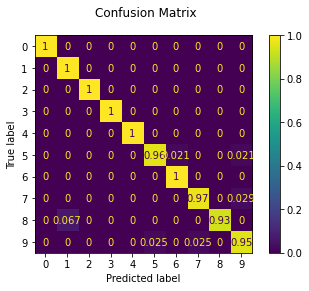

Number of neighbors = 20
Accuracy on train: 1.0
Accuracy on test: 0.9805555555555555
Model probabilities
[array([1.        , 1.        , 1.        , 0.84979379, 1.        ,
       0.79758312, 1.        , 1.        , 1.        , 0.93974598,
       1.        , 0.89690259, 0.94555234, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.86431061, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.90177999, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.87987528, 1.        , 1.        , 0.94036947,
       0.93539495, 1.        , 1.        , 1.        , 1.        ,
       0.93805844, 1.        , 0.58433888, 1.        , 1.        ,
       1.        , 0.87151467, 1.        , 1.        , 0.94450571,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.  

In [815]:
model = CustomKNeighborsClassifier(n_neighbors=15, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'Number of neighbors = {i}')
print("Accuracy on train:", train_acc)
print("Accuracy on test:", test_acc)
print('Model probabilities')
print(model.probabilities_all)

**As we can see below, when there are 30 neighbors accuracy on test is 0.975 which is slightly lower than accuracies when there are 3 neighbors, 8 neighbors and 15 neighbors, the model tends to confuse 5 with 6 and 9; 9 with 5, 7; 8 with 1. There are even more probabilities that are not 1 (actually more than half of probabilities are not 1) compared to situations when there are 3, 8 and 15 neighbors.**

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


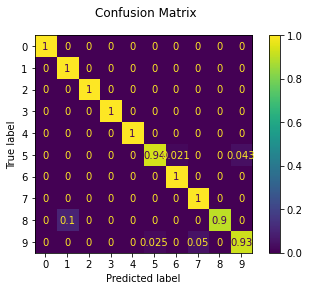

Number of neighbors = 20
Accuracy on train: 1.0
Accuracy on test: 0.975
Model probabilities
[array([1.        , 0.94115279, 1.        , 0.75216596, 1.        ,
       0.55339052, 1.        , 0.97239874, 1.        , 0.90545684,
       0.94153367, 0.53036353, 0.85544958, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.86160036, 1.        ,
       1.        , 1.        , 0.89683969, 1.        , 0.91289534,
       1.        , 0.94187847, 1.        , 1.        , 0.97115743,
       1.        , 1.        , 0.68528392, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.87448764, 1.        , 1.        , 0.96730456,
       0.90662572, 1.        , 1.        , 1.        , 1.        ,
       0.8756964 , 0.94114731, 0.59291707, 0.97083132, 1.        ,
       1.        , 0.74974064, 1.        , 1.        , 0.88832741,
       1.        , 1.        , 0.96982862, 1.        , 1.        ,
       1.        , 0.97183087, 1.   

In [816]:
model = CustomKNeighborsClassifier(n_neighbors=30, weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print(f'Number of neighbors = {i}')
print("Accuracy on train:", train_acc)
print("Accuracy on test:", test_acc)
print('Model probabilities')
print(model.probabilities_all)

To conclude, with ht, the output probability of the model contains more NOT 1 values (values that do not equal 1). Moreover, even though increase from 3 n_neighbors to 8 n_neighbots increased accuracy, after that with further increase of n_neighbors (15, 30) the accuracy started to decrease.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [706]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [707]:
PATH = "./data/"

In [708]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))
data = data.drop('PassengerId', axis=1)

In [709]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

#### Let's examine Sex column

In [710]:
data.Sex.value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

As we can see above there were 56114 males and 43886 females. So there were more males than females.

Text(0.5, 1.0, 'Distribution of Sex between male and female')

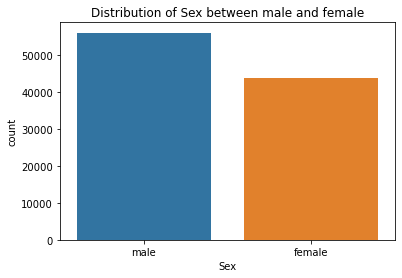

In [711]:
sns.countplot(x='Sex', data=data)
plt.title('Distribution of Sex between male and female')

In [712]:
print(f"Precisely, {100*data.Sex.value_counts()[0]/len(data)}% of passangers were male and {100*data.Sex.value_counts()[1]/len(data)}% of passengers were female in the dataset")

Precisely, 56.114% of passangers were male and 43.886% of passengers were female in the dataset


#### Let's examine Survived column

In [713]:
data.Survived.value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

As we can see 57226 passengers didn't survive and 42774 passengers survived. So more people didn't survive.

Text(0.5, 1.0, 'Not survived vs. Survived')

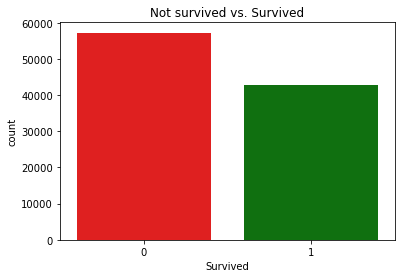

In [714]:
sns.countplot(x="Survived",data=data, palette=['red', 'green'])
plt.title('Not survived vs. Survived')

In [715]:
print(f"Precisely, {100*data.Survived.value_counts()[0]/len(data)}% of passengets didn't survived and {100*data.Survived.value_counts()[1]/len(data)}% of passengers survived")

Precisely, 57.226% of passengets didn't survived and 42.774% of passengers survived


#### The relathionship between survival and sex

According to the internet, the Captain ordered to save women first, so we can propose that women survival rate must be significantly higher.

Text(0.5, 1.0, 'Survival and Sex')

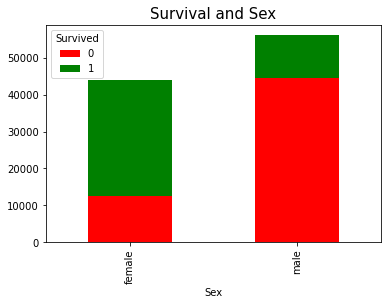

In [716]:
df2 = data.groupby(['Sex', 'Survived'])['Sex'].count().unstack('Survived')
df2[[0, 1]].plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Survival and Sex', fontsize=15)

**True, women chances to survive are significantly higher than chances of males.** As we can see above more than half of females survived.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

#### Let's plot the age distribution of passengers

In [717]:
data.Age.describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age'>

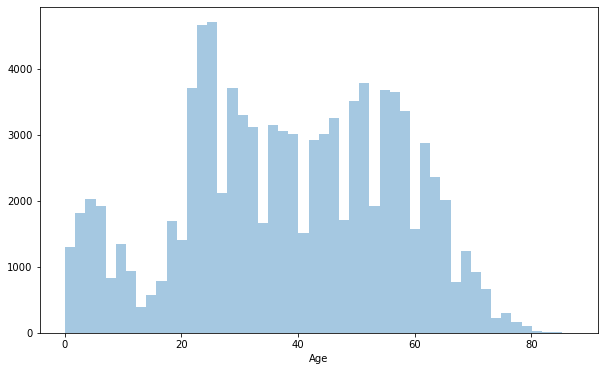

In [718]:
plt.figure(figsize=(10, 6))
sns.distplot(a=data['Age'], kde=False)

As we can see by the describe method and distplot, most of the passengers had an age around between 25 years old and 60 years old. Minimum age was less than 1 year old and maximum age was 87 years old. Mean and median age are almost the same - around 38/39 years old.

#### The average and the median age of survived and deceased passengers

Text(0.5, 1.0, 'Survival and Age')

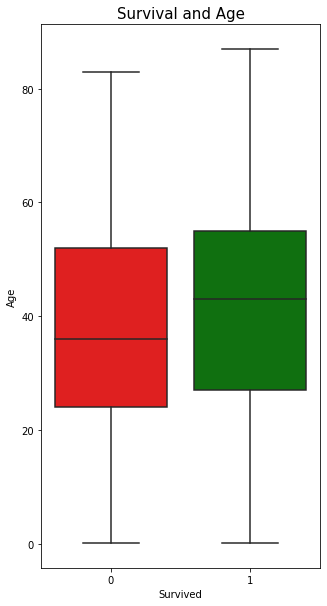

In [719]:
plt.figure(figsize=(5,10))
sns.boxplot(x='Survived', y="Age", data=data, palette=['red', 'green'])
plt.title('Survival and Age', fontsize=15)

In [720]:
data.groupby('Survived').Age.describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


As we can see by boxplots and describe method above, the average age for people who survived was around 40 years old while the median age was 43 years old.

The average age for deceased people was around 36 yeard old while median age was around 36 years old.

To conclude, average and median ages for people who survived were higher.

#### Do age distributions differ for survived and deceased passengers? Why?

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of passengers who survived in green and who did not survive in red')

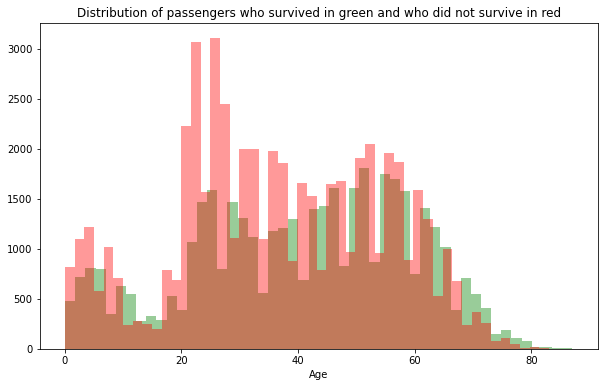

In [721]:
df_survived = data.loc[data['Survived'] == 1]
df_not_survived = data.loc[data['Survived'] == 0]
plt.figure(figsize=(10, 6))
sns.distplot(a=df_survived['Age'], color='green', kde=False)
sns.distplot(a=df_not_survived['Age'], color='red', kde=False)
plt.title('Distribution of passengers who survived in green and who did not survive in red')

As we can see from the graph above and a table below

In [722]:
data.groupby('Survived').Age.describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


Age distribution is different for passengers who survived and who didn't survive. This difference is that most of the people who survived had the age between 25 and 65 while most of passengers who did NOT survived had the age between 20 and 65 with big spikes for people with the age between 20 and 35. 

Moreover, you have more chances to survive if your age is around between 40 and 80. Spoiler: as we will see later the difference in distribution can be explained by the fact that older people 40+ years olds could afford more prestigious cabin classes and people in prestigious cabin classes (1st class, 2nd class) had higher chances to survive. Moreover, children between 0 and 15 had a good change for survival, may be that's because they were travelling with older 40+ people (their parents or grandparents).

To conclude, we can notice that overall the number of passengers who had the age between 20 and 60 was bigger than number of people in other age groups.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

#### What passenger class was "the safest"?

Text(0.5, 1.0, 'Survival and Pclass')

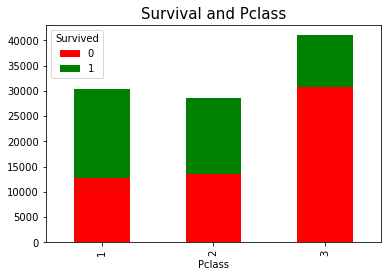

In [723]:
df2 = data.groupby(['Pclass', 'Survived'])['Pclass'].count().unstack('Survived')
df2[[0, 1]].plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Survival and Pclass', fontsize=15)

As we can see the "safest" class was 1st class and 2nd class is slightly less "safer" than the 1st. While people in the 3rd class had significantly lower chances of survival than people in the 1st and 2nd classes.

But why is it like this? May be that's because cabins for 1st and 2nd classes were on higher decks (in the second weeks Explaratory data analysis I explored decks and found that it is not very helpful data for predictions), so let's look at Pclasses from another angle. May be Pclasses' survival has to do with sexes.

Text(0.5, 1.0, 'Pclass and Sex')

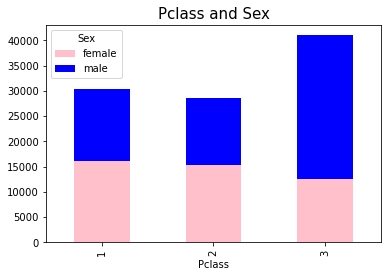

In [724]:
df2 = data.groupby(['Pclass', 'Sex'])['Pclass'].count().unstack('Sex')
df2[['female', 'male']].plot(kind='bar', stacked=True, color=['pink', 'blue'])
plt.title('Pclass and Sex', fontsize=15)

As we can see, yes, there were more Females in 1st and 2nd class and women as we had found out had the highest chance of survival.

Let's go a little deeper into exploring correlationships of Age. We found that older people 40+ had higher chances to survive. May be that has to do with Pclasses.

In [725]:
data.groupby('Pclass').Age.describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,29353.0,44.774464,14.706884,0.08,35.0,47.0,56.0,83.0
2,27731.0,38.631237,19.269780,0.08,24.0,38.0,55.0,87.0
3,39624.0,33.407362,18.531413,0.08,22.0,30.0,49.0,85.0


Yes, as we can see my assumption is true, as we can se by mean and median ages older people on average tended to preferr more prestigious classes.

For example, for 1st class mean age is 44, for 2nd class is 38 and for 3rd class is 33.

We could've gone even deeper into exploring Pclass here but I had already done it in a Explaratory Data Analysis task during the week 2, so let's move on to the Embarked feature.

#### Is there any relationship between the embarkation port and the survival?

There is a very small change that port city could influence Survival because all of this cities are ports relatively in the same area (France, England and Ireland), and a lot of people who came on board of Titanic from those ports could be living in different cities.

Text(0.5, 1.0, 'Relationship between Embarked and Survival')

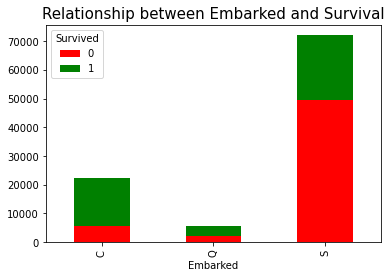

In [726]:
df2 = data.groupby(['Embarked', 'Survived'])['Embarked'].count().unstack('Survived')
df2[[0, 1]].plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Relationship between Embarked and Survival', fontsize=15)

As we can see there is a difference in survival between ports. People from 'C' and 'Q' ports tended to survive. But it can be caused by other factors like Pclass, Sex or Age. Let's check them.

Text(0.5, 1.0, 'Relationship between Embarked and Pclass')

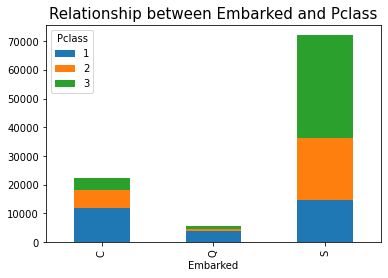

In [727]:
df2 = data.groupby(['Embarked', 'Pclass'])['Embarked'].count().unstack('Pclass')
df2[[1, 2, 3]].plot(kind='bar', stacked=True)
plt.title('Relationship between Embarked and Pclass', fontsize=15)

Around 80% of people in 'C' and 'Q' ports had cabins in 1st and 2nd classes while half of people from 'S' port had cabins of 3rd class.

It can explain why people in 'C' and 'Q' ports tended to survive because people in 1st and 2nd classes had higher chances of survival.

Text(0.5, 1.0, 'Relationship between Embarked and Sex')

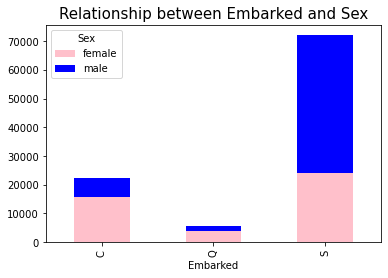

In [728]:
df2 = data.groupby(['Embarked', 'Sex'])['Embarked'].count().unstack('Sex')
df2[['female', 'male']].plot(kind='bar', stacked=True, color=['pink', 'blue'])
plt.title('Relationship between Embarked and Sex', fontsize=15)

Majority of people from 'C' and 'Q' ports were females, and as we know women tend to survive, so again higher rate of survival of people from 'C' and 'Q' ports can be explained.

**To conclude, there is an assosiation between Embarked and Survival but not the relationship because as we explained above people tended to survive when they were embarked in certain ports because in certain ports there were more females and 1st/2nd Pclasses.**

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [729]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns
missing_values_table(data)

There are 5 columns that have missing values.


,Missing Values,% of Total Values
Cabin,67866,67.9
Ticket,4623,4.6
Age,3292,3.3
Embarked,250,0.2
Fare,134,0.1


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**My suggesions of the ways that w could handle the missing values:**
1. Cabin. Because there are 67.9% of missing data in Cabin column, it would be too difficult to relatively correctly fill the missing values, so we cannot use imputation.
    - Imputation. Advantage - no. Disagvantage - too much of values are lost, so we cannot correctly impute values. 
    - Replace missing Cabin columns with "No cabin". Advantage - will provide usefull information if the absense of a cabin matters (may be people who have no cabin did NOT survive and that's why could not tell their cabin number). Disadvantage - will provide useless unnessesary information if the absense of a cabin doesn't matter.
    - Delete the Cabin column. Advantage - we will get rid from an unnessery distractor. Disadvantage - if the absense of a cabin number matter, we will get rid of usefull information. **I will use it**
2. Ticket. According to articles about the tickets at the internet, people could have the same ticket number if they shared the same cabin. Moreover, tickets can be divided in different groups based on their pattern. For example, tickets that start with 'CA' were sold by the same seller, tickets that start with 'A' were sold by the same seller and etc. Let's check it in our dataset by counting unique values.

In [730]:
data.Ticket.value_counts()

A/5             602
C.A.            177
SC/PARIS        145
SOTON/O.Q.       80
SC               57
               ... 
421812            1
PC 420601         1
PC 26800          1
STON/O 23755      1
458074            1
Name: Ticket, Length: 75331, dtype: int64

Logically, 602 people or 177 people couldn't share the same cabin. Moreover, information about sellers cannot influence other features but Fare. Consequently, ticket value is not so important.

    - Imputation with mode. It has no advantages because as we understood above - ticket data is barely usefull. It might have a disadvantage if the absense of Ticket data influences survival. May be a person didn't survive and that's why his Ticket value is missing because there is no one to tell about it.
    - Delete Ticket column. Advantage - we do not make any prediction with which to impute Tickets, so we don't change values and we loose almost nothing by deleting becayse only 4.6% of tickets is NAN. A disadvantage - may be certain passengers lacked Ticket numbers because they died and noone could tell whey they Ticket Numbers were. In other words, the value of a Ticket might not matter but the absense of a Ticket value might matter. **I will use it**
    - Replace NaNs with 'no ticket' words. Advantage - if absense of a Ticket value influences survival, than we keep this influence. Disadvantage - if it doesn't, we feed an unnessesary column to our model and might decrease its performance.

3. Age.
    - Imputation with median. Advantage - let's us use raws that otherwise would be deleted. Disadvantage - we saw that age is correlated with Pclass and can be also correlated with Sex, so we will not relatively correctly predict values to impute.
    - Imputation with median based on sex and Pclass of the passenger. Advantage - we can more accuratelly estimate values to impute. Disadvantage - (may be we could use mean instead of median. **I will use it**
    - Delete raws in which age is missing. Advantage - we don't need to estimate values to impute. Disadvantage - we might do more harm to predictions by deleting raws with missing age.
4. Embarked.
    - Imputation with mode. Advantage - we will keep the raws and our estimations might have no harm on the results because percent of missing embarked data is too small. Disadvantage - no. **I will use it**
    - Delete raws in which Embarked is missing. Advantage - we will not replace NaN values with bad estimations. Disadvantage - we might loose raws with valuable data.
5. Fare.
    - Imputation with mean. Advantage - we will keep the raws and our estimations might have no harm on the results because percent of missing fare data is too small. Disadvantage - mean might differ between Pclasses, so our estimations are not so accurate.
    - Imputation with mean based on Pclass. Advantage - we can more accuratelly estimate our values. Disadvantage - I don't see any. **I will use it**
    - Delete raws in which Fare is missing.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

### Prepare the features

Remember that we need to do the same changes to test dataset as we did to train dataset, so let's load train dataset.

In [731]:
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
test = test.drop('PassengerId', axis=1)

#### Deal with missing data

Cabin, as said above let's drop the whole column.

In [732]:
data.drop(['Cabin'],axis=1,inplace=True)
test.drop(['Cabin'],axis=1,inplace=True)
missing_values_table(data)

There are 4 columns that have missing values.


,Missing Values,% of Total Values
Ticket,4623,4.6
Age,3292,3.3
Embarked,250,0.2
Fare,134,0.1


Ticket, as said above let's delete the Ticket column

In [733]:
data.drop(['Ticket'],axis=1,inplace=True)
test.drop(['Ticket'],axis=1,inplace=True)
missing_values_table(data)

There are 3 columns that have missing values.


,Missing Values,% of Total Values
Age,3292,3.3
Embarked,250,0.2
Fare,134,0.1


Age, as said above let's replace age NaN values with median values for that Pclass and Sex.

In [734]:
data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda group: group.fillna(group.median()))
test['Age'] = test.groupby(['Pclass', 'Sex'])['Age'].transform(lambda group: group.fillna(group.median()))

In [735]:
missing_values_table(data)

There are 2 columns that have missing values.


,Missing Values,% of Total Values
Embarked,250,0.2
Fare,134,0.1


Embarked, as said above let's replace with a mode.

In [736]:
embarked_mode = data.Embarked.mode()[0]
data['Embarked'] = data['Embarked'].fillna(embarked_mode)
embarked_mode = test.Embarked.mode()[0]
test['Embarked'] = test['Embarked'].fillna(embarked_mode)
missing_values_table(data)

There are 1 columns that have missing values.


,Missing Values,% of Total Values
Fare,134,0.1


Fare, as said above let's replace with mean for a certain Pclass.

In [737]:
first_class_mean = data.loc[data.Pclass == 1].Fare.mean()
second_class_mean = data.loc[data.Pclass == 2].Fare.mean()
third_class_mean = data.loc[data.Pclass == 3].Fare.mean()
data['Fare'] = data.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.mean()))

first_class_mean = test.loc[test.Pclass == 1].Fare.mean()
second_class_mean = test.loc[test.Pclass == 2].Fare.mean()
third_class_mean = test.loc[test.Pclass == 3].Fare.mean()
test['Fare'] = test.groupby('Pclass')['Fare'].transform(lambda group: group.fillna(group.mean()))

missing_values_table(data)

There are 0 columns that have missing values.


,Missing Values,% of Total Values


Now there are no missing values.

Let's ommit Name feature cause it has no value for prediction in it.

In [738]:
data.drop(['Name'],axis=1,inplace=True)
test.drop(['Name'],axis=1,inplace=True)

#### Feature engineering

#### Family column

In [739]:
# def get_size(df):
#     if df['SibSp'] + df['Parch'] + 1 == 1:
#         return 'Single'
#     if df['SibSp'] + df['Parch'] + 1 > 1:
#         return 'Small'
#     if df['SibSp'] + df['Parch'] + 1 > 4:
#         return 'Big'
#     if df['SibSp'] + df['Parch'] + 1 > 10:
#         return 'Very Big'
    
# data['FamilySize'] = data.apply(get_size,axis=1)
# test['FamilySize'] = test.apply(get_size,axis=1)
data['FamilySize'] = data['SibSp'] + data['Parch']
test['FamilySize'] = test['SibSp'] + test['Parch']
data['IsAlone'] = 1 
data['IsAlone'].loc[data['FamilySize'] != 0] = 0
test['IsAlone'] = 1 
test['IsAlone'].loc[test['FamilySize'] != 0] = 0

C:\Users\Anzhe\AppData\Local\Temp/ipykernel_16600/1521478730.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsAlone'].loc[data['FamilySize'] != 0] = 0
C:\Users\Anzhe\AppData\Local\Temp/ipykernel_16600/1521478730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['IsAlone'].loc[test['FamilySize'] != 0] = 0


In [740]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,1,1,male,44.00,2,0,27.14,S,2,0
1,0,3,male,31.00,0,0,13.35,S,0,1
2,0,3,male,0.33,1,2,71.29,S,3,0
3,0,3,male,19.00,0,0,13.04,S,0,1
4,1,3,male,25.00,0,0,7.76,S,0,1
...,...,...,...,...,...,...,...,...,...,...
99995,1,2,female,62.00,0,0,14.86,C,0,1
99996,0,2,male,66.00,0,0,11.15,S,0,1
99997,0,3,male,37.00,0,0,9.95,S,0,1
99998,0,3,male,51.00,0,1,30.92,S,1,0


#### Cabin column

#### Ticket column

#### Transform categorical data into numerical

Let's transform categorical data into numbers, so our model can learn from it.

In [741]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

In [742]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,male,19.0,0,0,63.01,S,0,1
1,3,female,53.0,0,0,5.81,S,0,1
2,1,female,19.0,0,0,38.91,C,0,1
3,2,male,25.0,0,0,12.93,S,0,1
4,1,female,17.0,0,2,26.89,C,2,0
...,...,...,...,...,...,...,...,...,...
99995,3,female,27.0,0,0,10.12,Q,0,1
99996,1,male,59.0,1,0,68.31,S,1,0
99997,3,male,47.0,0,0,10.87,S,0,1
99998,1,female,49.0,1,2,29.68,C,3,0


In [743]:
non_numeric_features = ['Embarked', 'Sex']
for feature in non_numeric_features:
    data[feature] = LabelEncoder().fit_transform(data[feature])
for feature in non_numeric_features:
    test[feature] = LabelEncoder().fit_transform(test[feature])

Now let's use HotEncoder, so our model doesn't assume that some value like (0, 1, 2) in Embarked has more priority than another.

In [744]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(data[['Pclass']]).toarray())
enc_df.columns = enc.get_feature_names(['Pclass'])
data = data.join(enc_df)
data.drop(columns='Pclass', inplace=True)
enc_df = pd.DataFrame(enc.fit_transform(data[['Sex']]).toarray())
enc_df.columns = enc.get_feature_names(['Sex'])
data = data.join(enc_df)
data.drop(columns='Sex', inplace=True)
# enc_df = pd.DataFrame(enc.fit_transform(data[['SibSp']]).toarray())
# enc_df.columns = enc.get_feature_names(['SibSp'])
# data = data.join(enc_df)
# data.drop(columns='SibSp', inplace=True)
# enc_df = pd.DataFrame(enc.fit_transform(data[['Parch']]).toarray())
# enc_df.columns = enc.get_feature_names(['Parch'])
# data = data.join(enc_df)
# data.drop(columns='Parch', inplace=True)
enc_df = pd.DataFrame(enc.fit_transform(data[['FamilySize']]).toarray())
enc_df.columns = enc.get_feature_names(['FamilySize'])
data = data.join(enc_df)
data.drop(columns='FamilySize', inplace=True)
data.drop(columns='Parch', inplace=True)
data.drop(columns='SibSp', inplace=True)
enc_df = pd.DataFrame(enc.fit_transform(data[['Embarked']]).toarray())
enc_df.columns = enc.get_feature_names(['Embarked'])
data = data.join(enc_df)
data.drop(columns='Embarked', inplace=True)

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-p

In [745]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,1,19.0,0,0,63.01,2,0,1
1,3,0,53.0,0,0,5.81,2,0,1
2,1,0,19.0,0,0,38.91,0,0,1
3,2,1,25.0,0,0,12.93,2,0,1
4,1,0,17.0,0,2,26.89,0,2,0
...,...,...,...,...,...,...,...,...,...
99995,3,0,27.0,0,0,10.12,1,0,1
99996,1,1,59.0,1,0,68.31,2,1,0
99997,3,1,47.0,0,0,10.87,2,0,1
99998,1,0,49.0,1,2,29.68,0,3,0


In [746]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(test[['Pclass']]).toarray())
enc_df.columns = enc.get_feature_names(['Pclass'])
test = test.join(enc_df)
test.drop(columns='Pclass', inplace=True)
enc_df = pd.DataFrame(enc.fit_transform(test[['Sex']]).toarray())
enc_df.columns = enc.get_feature_names(['Sex'])
test = test.join(enc_df)
test.drop(columns='Sex', inplace=True)
# enc_df = pd.DataFrame(enc.fit_transform(test[['SibSp']]).toarray())
# enc_df.columns = enc.get_feature_names(['SibSp'])
# test = test.join(enc_df)
# test.drop(columns='SibSp', inplace=True)
# enc_df = pd.DataFrame(enc.fit_transform(test[['Parch']]).toarray())
# enc_df.columns = enc.get_feature_names(['Parch'])
# test = test.join(enc_df)
# test.drop(columns='Parch', inplace=True)
enc_df = pd.DataFrame(enc.fit_transform(test[['FamilySize']]).toarray())
enc_df.columns = enc.get_feature_names(['FamilySize'])
test = test.join(enc_df)
test.drop(columns='FamilySize', inplace=True)
test.drop(columns='Parch', inplace=True)
test.drop(columns='SibSp', inplace=True)
enc_df = pd.DataFrame(enc.fit_transform(test[['Embarked']]).toarray())
enc_df.columns = enc.get_feature_names(['Embarked'])
test = test.join(enc_df)
test.drop(columns='Embarked', inplace=True)

D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\MiniConda\envs\rsschool-machine-learning-course\lib\site-p

In [747]:
data = data.drop('FamilySize_14', axis=1)
data = data.drop('FamilySize_12', axis=1)

In [748]:
test

,Age,Fare,IsAlone,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,FamilySize_0,FamilySize_1,...,FamilySize_7,FamilySize_8,FamilySize_9,FamilySize_10,FamilySize_11,FamilySize_13,FamilySize_17,Embarked_0,Embarked_1,Embarked_2
0,19.0,63.01,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,53.0,5.81,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,19.0,38.91,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,25.0,12.93,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,17.0,26.89,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,27.0,10.12,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99996,59.0,68.31,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99997,47.0,10.87,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99998,49.0,29.68,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### KNN

In [749]:
# scaler = StandardScaler()
# X = data.drop('Survived',axis=1)
# y = data['Survived']
# knn = KNeighborsClassifier(n_neighbors = 3) 
# scaled_X = scaler.fit_transform(X)
# scores = cross_validate(knn, scaled_X, y, scoring='accuracy', cv=5)
# print(scores['test_score'])

#### Logistic Regression

In [750]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
scaler = MinMaxScaler()
X = data.drop('Survived',axis=1)
y = data['Survived']
transformer = ColumnTransformer(transformers=[('cat', scaler, ['Age', 'Fare'])], remainder='passthrough')
scaled_X = transformer.fit_transform(X)
model = LogisticRegression(max_iter=1000)
scores = cross_validate(model, scaled_X, y, scoring='accuracy', cv=5)
print(scores['test_score'])

[0.766   0.7627  0.76305 0.7649  0.76315]


For now our score equals 0.76.

In [751]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(scaled_X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

True, my model didn't work well initially, so I started changing things. For my convenience, I will perform actions to improve the model in previous steps in order not to produce repetition of code here. Below, I will track how the score changes between iterations.
1. First iteration of work. My initial score in Logistical Regression with train data is 0.76.

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [752]:
data

,Survived,Age,Fare,IsAlone,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,FamilySize_0,...,FamilySize_7,FamilySize_8,FamilySize_9,FamilySize_10,FamilySize_11,FamilySize_13,FamilySize_17,Embarked_0,Embarked_1,Embarked_2
0,1,44.00,27.14,0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,31.00,13.35,1,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0.33,71.29,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,19.00,13.04,1,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,25.00,7.76,1,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,62.00,14.86,1,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99996,0,66.00,11.15,1,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99997,0,37.00,9.95,1,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99998,0,51.00,30.92,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [753]:
transformer = ColumnTransformer(transformers=[('cat', scaler, ['Age', 'Fare'])], remainder='passthrough')
scaled_test = transformer.fit_transform(test)
test2 = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
model.fit(scaled_X, y)
output = pd.DataFrame({'PassengerId': test2['PassengerId']})
output['Survived'] = model.predict(scaled_test)
output.to_csv('Titanic_with_logistic.csv', index=False)